# Factorial Design

In [42]:
# 3d Dataframe test
import pandas as pd

indices = [['a', 'b'], ['c', 'd']]
multi_index = pd.MultiIndex.from_product(indices)

data = [[1, 2], [3, 4], [5, 6], [7, 8]]

df = pd.DataFrame(data, index=multi_index)
df

0  1
a c  1  2
  d  3  4
b c  5  6
  d  7  8

# By Hand

In [2]:
import pandas as pd

indices = [['mat_1', 'mat_2', 'mat_3'], ['15_deg', '70_deg', '125_deg']]
multi_index = pd.MultiIndex.from_product(indices)

data = [
    [130, 155, 74, 180], 
    [34, 40, 80, 75],
    [20, 70, 82, 58],
    [150, 188, 159, 126],
    [136, 122, 106, 115],
    [25, 70, 58, 45],
    [138, 110, 168, 160],
    [174, 120, 150, 139],
    [96, 104, 82, 60]
       ]

df = pd.DataFrame(data, index=multi_index, columns=[1, 2, 3, 4])
df

1    2    3    4
mat_1 15_deg   130  155   74  180
      70_deg    34   40   80   75
      125_deg   20   70   82   58
mat_2 15_deg   150  188  159  126
      70_deg   136  122  106  115
      125_deg   25   70   58   45
mat_3 15_deg   138  110  168  160
      70_deg   174  120  150  139
      125_deg   96  104   82   60

In [3]:
a = len(df.index.levels[0])
b = len(df.index.levels[1])
n = len(df.columns)

grand_total = df.sum().sum()
a_totals = df.groupby(level=0).sum().sum(axis=1).values
b_totals = df.groupby(level=1).sum().sum(axis=1).values
cell_totals = df.sum(axis=1).values

print(a, b, n, grand_total, a_totals, b_totals, cell_totals)

3 3 4 3799 [ 998 1300 1501] [ 770 1738 1291] [539 229 230 623 479 198 576 583 342]


In [4]:
ss_t = sum([i**2 for i in df.values.flatten()]) - (grand_total**2)/(a*b*n)
ss_a = sum([i**2 for i in a_totals])/(b*n) - (grand_total**2)/(a*b*n)
ss_b = sum([i**2 for i in b_totals])/(a*n) - (grand_total**2)/(a*b*n)
ss_axb = sum([i**2 for i in cell_totals])/n - (grand_total**2)/(a*b*n) - ss_a - ss_b
ss_e = ss_t - ss_a - ss_b - ss_axb

print(ss_t, ss_a, ss_b, ss_axb, ss_e)

77646.9722222 10683.7222222 39118.7222222 9613.77777778 18230.75


In [5]:
dof_a = a - 1 
dof_b = b - 1
dof_axb = dof_a*dof_b
dof_e = a*b*(n - 1)
dof_t = n*a*b - 1

dof_t == dof_a + dof_b + dof_axb + dof_e

True

In [6]:
mean_ss_t = ss_t/dof_t
mean_ss_a = ss_a/dof_a
mean_ss_b = ss_b/dof_b
mean_ss_axb = ss_axb/dof_axb
mean_ss_e = ss_e/dof_e

In [41]:
f_a = mean_ss_a/mean_ss_e
f_b = mean_ss_b/mean_ss_e
f_axb = mean_ss_axb/mean_ss_e
print('Material Type F0: ', f_a)
print('Temperature F0: ', f_b)
print('Interaction F0: ', f_axb)

Material Type F0:  7.91137226938
Temperature F0:  28.967691949
Interaction F0:  3.55953540035


# With statsmodels

In [8]:
data = [
    [130, 155, 74, 180], 
    [34, 40, 80, 75],
    [20, 70, 82, 58],
    [150, 188, 159, 126],
    [136, 122, 106, 115],
    [25, 70, 58, 45],
    [138, 110, 168, 160],
    [174, 120, 150, 139],
    [96, 104, 82, 60]
       ]

data = [item for l in data for item in l]
material = [1]*12 + [2]*12 + [3]*12
temp = [15]*4 + [70]*4 + [125]*4
temp = temp*3

df_new = pd.DataFrame({'Batt_Life': data, 'Mat_Type': material, 'Temp': temp})
df_new

,Batt_Life,Mat_Type,Temp
0,130,1,15
1,155,1,15
2,74,1,15
3,180,1,15
4,34,1,70
5,40,1,70
6,80,1,70
7,75,1,70
8,20,1,125
9,70,1,125


In [29]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
formula = ('Batt_Life ~ C(Mat_Type) + C(Temp) + C(Mat_Type):C(Temp)')
res = ols(formula, data=df_new).fit()
aov_table = anova_lm(res, typ=2)
print(aov_table)

                           sum_sq    df          F        PR(>F)
C(Mat_Type)          10683.722222   2.0   7.911372  1.976083e-03
C(Temp)              39118.722222   2.0  28.967692  1.908596e-07
C(Mat_Type):C(Temp)   9613.777778   4.0   3.559535  1.861117e-02
Residual             18230.750000  27.0        NaN           NaN


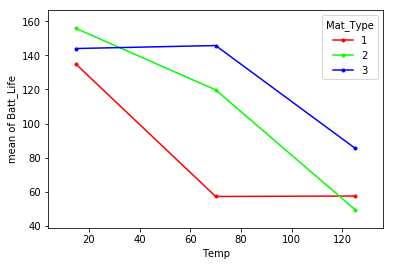

In [17]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(df_new.Temp, df_new.Mat_Type, df_new.Batt_Life)
plt.show()

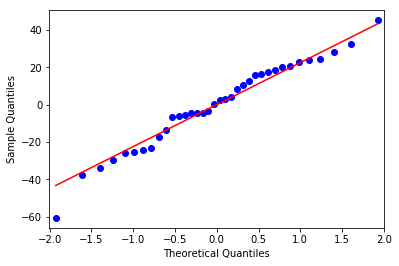

In [32]:
from statsmodels.graphics.gofplots import qqplot
resid = res.resid
fig = qqplot(resid, line='s')
plt.show()

# No repeated observations

In [39]:
data_imp = [
    [5, 4, 6, 3, 5], 
    [3, 1, 4, 2, 3],
    [1, 1, 3, 1, 2]
    ]

data_imp = [item for l in data_imp for item in l]
temp = [100]*5 + [125]*5 + [150]*5
pres = [25, 30, 35, 40, 45]
pres = pres*3

df_imp = pd.DataFrame({'Impurity': data_imp, 'Temp': temp, 'Pressure': pres})
df_imp

,Impurity,Pressure,Temp
0,5,25,100
1,4,30,100
2,6,35,100
3,3,40,100
4,5,45,100
5,3,25,125
6,1,30,125
7,4,35,125
8,2,40,125
9,3,45,125


In [40]:
formula = ('Impurity ~ C(Pressure) + C(Temp) + C(Temp):C(Pressure)')
res = ols(formula, data=df_imp).fit()
# aov_table = anova_lm(res, typ=2)
# print(aov_table)